In [1]:
import cv2 
import os
import matplotlib.pyplot as plt
import matplotlib.image as im
import numpy as np
import math
import pandas as pd


In [2]:
def show_img(img):
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

In [295]:
def get_pointer_inclination(img):
    lines = []
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray2[(gray2[:,:] < 220)] = 0
    #plt.imshow(gray2,cmap='gray')
    #plt.show()
    
    #Getting line params of the pointer using Hough Line method
    try:
        lines = cv2.HoughLinesP(image=gray2, rho=3, theta=np.pi / 180, threshold=100,minLineLength=100, maxLineGap=10) 
        return lines[0][0]
    except Exception as e:
        print(e)
        return None

In [4]:
#Function to calculate the average parms for the circle
def avg_circles(circles,b):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))
    return avg_x, avg_y, avg_r

In [23]:
def get_region_of_interest(img,tolerance=50):
#     img_raw = img[:,350:1600]
    img_raw = np.copy(img)
    #Converting to gray-scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    plt.imshow(gray,cmap='gray')
    plt.title('Gray-scale Image')
    plt.show()
    print(gray.shape)
    height,width = gray.shape
    
    #Getting circle params
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20,minRadius=400,maxRadius=width-50)
    a, b, c = circles.shape
    
    #Getting avg circle param
    x,y,r = avg_circles(circles,b)
    
    #Increasing the radius of the circle 
    r = r+tolerance
    
    #Drawing circle
    #cv2.circle(img,(x,y),r,(0,255,0),10)
    #plt.title('ROI Image')
    #show_img(img)
    
    #Masking the region of interest
    mask = np.zeros_like(img_raw)
    mask = cv2.circle(mask, (x,y), r, (255,255,255), -1)
    masked_img = cv2.bitwise_and(img_raw,mask)
#     plt.title('Masked Image')
    #show_img(masked_img)
    return masked_img

In [24]:
def get_speed(df,data_num):
    print(df.head())
    length = df.shape[0]
    speeds = []
    considered = []
    avoided = []
    m1 = None
    
    try:
        for i in range(0,length,2): 
            #Getting slope of the line for the reference
            if(m1==None):
                im1 = cv2.imread(df['speedometer'][0])
                imgm_1 = get_region_of_interest(im1)
                p1 = get_pointer(imgm_1)
                x11,y11,x12,y12 = p1
                m1 = (y12-y11)/(x12-x11)
                print('m1 :',m1)
                speeds.append(0.0)
                considered.append(1)
                continue

            #Current image
            im2 = cv2.imread(df['file'][i])
            imgm_2 = get_region_of_interest(im2)

            #Getting slope params of pointer
            p2 =get_pointer(imgm_2)
            x21,y21,x22,y22 = p2

            #Calculating slope
            m2 = (y22-y21)/(x22-x21)

            #Calculating the angle
            angle = (math.degrees(math.atan((m1 -m2)/(1+m1*m2))))
            considered.append(i)
            print(angle)
            speeds.append(angle)
            print(f'{i}/{length}')
    except Exception as e:
        print(e)
        avoided.append(i)
    
    df = pd.DataFrame({'speed':speeds,'taken':considered})
    df.to_csv(f'speed_data_{data_num}.csv')
    

In [25]:
def video_to_images(data_num,env_video_path,speedometer_video_path,env_imges_dir,speedometer_imges_dir,start_num):
    #Capturing video
    cap1 = cv2.VideoCapture(speedometer_video_path) 
    cap2 = cv2.VideoCapture(env_video_path) 
    
    cap1_len = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))
    cap2_len = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #Total frames
    total_frames = int(min(cap1_len,cap2_len)/3)
    
    print('Total no. of frames : ',total_frames)
    
    img_no=start_num
    
    sp_paths = []
    env_paths = []
    idx = 0
    while(cap1.isOpened() and cap2.isOpened()):
        print(f'{img_no}/{total_frames}')
        try:
            #Getting the images from the video capture
            _, speedometer_frame = cap1.read()
            _, env_frame = cap2.read()
            
            #Skipping every second image
            if(idx % 3 == 0):
                idx += 1
                continue
            
            #File path for speedometer image
            sp_img_path = os.path.join(os.getcwd(),speedometer_imges_dir,f'speedometer_{img_no}.png')
            
            #File paths for environment image
            env_img_path = os.path.join(os.getcwd(),env_imges_dir,f'car_{img_no}.png')
            
            
            #Saving the images
            cv2.imwrite(sp_img_path,speedometer_frame)
            sp_paths.append(sp_img_path)
            
            cv2.imwrite(env_img_path, env_frame)
            env_paths.append(env_img_path)

        except Exception as e:
            print(e)
            break
            
        #Delaying for 1mili second
        if cv2.waitKey(1) == ord('q'): 
            break 
        idx += 1
        img_no += 1
        
    df = pd.DataFrame({
        'speedometer':sp_paths,
        'environment':env_paths
    })
    
    df.to_csv(f'data_csv\data{data_num}.csv')
        
    cap1.release()  
    cap2.release()  
    cv2.destroyAllWindows()
    
    return img_no



### Folder Structure

In [8]:
data = {
    'images':[['environment_1','speedometer_1'],
              ['environment_2','speedometer_2'],
              ['environment_3','speedometer_3'],
              ['environment_4','speedometer_4']],
    'videos':{
        'cleaned_data':{
            'data1':['data1_car','data1_speedometer'],
            'data2':['data2_car','data2_speedometer'],
            'data3':['data3_car','data3_speedometer'],
            'data4':['data4_car','data4_speedometer']
            
        }
    },
}

### Converting Video to Images

In [137]:
MAX_DATA_NUMS = 3

for i in range(3,MAX_DATA_NUMS+1):
    
    #Different file and folder paths
    env_video_path = f'videos\\cleaned_data\\data{i}\\data{i}_car.mp4'
    speedometer_video_path = f'videos\\cleaned_data\\data{i}\\data{i}_speedometer.mp4'
    env_imges_dir = f'images\\environment_{i}'
    speedometer_imges_dir = f'images\\speedometer_{i}'
    num_imgs = 0
    
    #Crementing the no. of images 
    num_imgs += video_to_images(i,env_video_path,speedometer_video_path,env_imges_dir,speedometer_imges_dir,num_imgs)
        

### Getting Speed from the images

   Unnamed: 0                                        speedometer  \
0           0  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...   
1           1  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...   
2           2  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...   
3           3  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...   
4           4  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...   

                                         environment  
0  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...  
1  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...  
2  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...  
3  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...  
4  C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...  


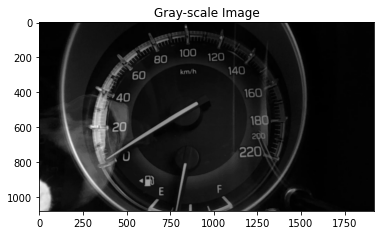

(1080, 1920)
'NoneType' object has no attribute 'shape'


In [26]:
MAX_DATA_NUMS = 1
for i in range(1,MAX_DATA_NUMS+1):
    df = pd.read_csv(f'data_csv\data{i}.csv')
    get_speed(df,i)

In [27]:

df

,Unnamed: 0,speedometer,environment
0,0,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...
1,1,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...
2,2,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...
3,3,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...
4,4,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...
...,...,...,...
6619,6619,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...
6620,6620,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...
6621,6621,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...
6622,6622,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...,C:\Chethan\SelfDrivingCars\Simulator\E-Minor-P...


In [296]:
def detect_lines(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_blur=cv2.GaussianBlur(img_gray,(7,7),0)
    img_canny = cv2.Canny(img_blur,50,200,apertureSize=3)
    plt.imshow(img_canny,cmap='gray')
    plt.show()
    
    rho_acc = 1
    theta_acc = np.pi/180
    thresh = 300
    lines = []
    status = True
    lines = cv2.HoughLines(img_canny,rho_acc,theta_acc,thresh)
    lines2 = cv2.HoughLinesP(image=img_canny, rho=3, theta=np.pi / 180, threshold=100,minLineLength=100, maxLineGap=10) 
    
    if lines is None:
        status = False
        
        
    return status,lines,lines2

In [297]:
def get_theta(lines,avg=True,tolerance=None):
    try:
        lines = lines.reshape(-1,2)
        for line in lines:
            print(line[1])
        rho = lines[0][0]
        theta = lines[0][1]
        return math.degrees(theta)
    except Exception as e:
        print(e)
            

In [304]:
def draw_line(img,lines):
    try:
        lines = lines.reshape(-1,2)
        for line in lines:
            rho = line[0]
            theta = line[1]
            x0 = rho*np.cos(theta) 
            y0 = rho*np.sin(theta)
            a = np.cos(theta)
            b = np.sin(theta)

            x1 = int(x0 + 1000*(-b))
            x2 = int(x0 - 1000*(-b))
            y1 = int(y0 + 1000*a)
            y2 = int(y0 - 1000*a)
            
            print(math.degrees(theta))

            cv2.line(img,(x1*600,y1*600),(x2*600,y2*600),(0,255,0),4)
        return img
    except AttributeError as e:
        print("No line found!")

In [305]:
def get_speed(angle1,angle2):
    return abs(angle1-angle2)

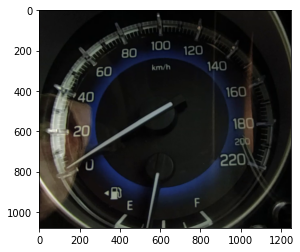

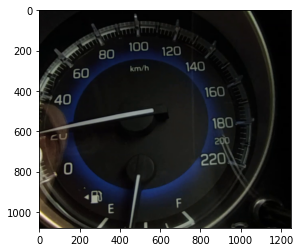

In [306]:
im1 = cv2.imread(df['speedometer'][0])
im2 = cv2.imread(df['speedometer'][400])
im1 = im1[:,250:1500]
im2 = im2[:,250:1500]
show_img(im1)
show_img(im2)

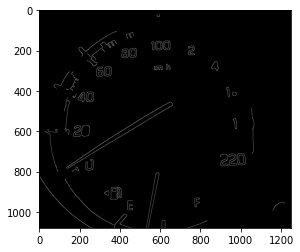

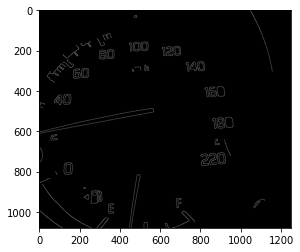

(True,
 array([[[744.       ,   1.0297443]]], dtype=float32),
 array([[[ 310,  682,  662,  471]],
 
        [[ 452,  571,  602,  481]],
 
        [[ 188,  744,  335,  645]],
 
        [[ 531, 1079,  578,  817]],
 
        [[ 557, 1002,  585,  861]],
 
        [[ 201,  749,  319,  676]],
 
        [[ 192,  754,  306,  683]],
 
        [[ 543, 1070,  572,  924]]], dtype=int32),
 False,
 None,
 array([[[ 246,  545,  381,  518]],
 
        [[   0,  611,  187,  575]],
 
        [[ 369,  541,  518,  514]],
 
        [[ 456, 1079,  501,  820]],
 
        [[ 447, 1079,  478,  863]],
 
        [[ 373,  519,  476,  500]],
 
        [[   0,  604,  200,  555]],
 
        [[ 414,  532,  566,  505]]], dtype=int32))

In [307]:
status1,l1,l11 = detect_lines(im1)
status2,l2 ,l22= detect_lines(im2)
status1,l1,l11,status2,l2 ,l22

1.0297443
'NoneType' object has no attribute 'reshape'
59.00000050345972
No line found!


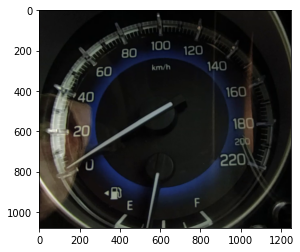

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [308]:
th1 = get_theta(l1)
th2 = get_theta(l2)
img1 = draw_line(np.copy(im1),l1)
img2 = draw_line(np.copy(im2),l2)
show_img(img1)
show_img(img2)

In [ ]:
get_speed(th1,th2)